In [240]:
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra.auth import PlainTextAuthProvider
from cassandra import WriteTimeout

from pyspark.sql import SparkSession
from pyspark.sql.functions import col

import pandas as pd
import numpy as np

from scipy.optimize import minimize

import seaborn as sns
import matplotlib.pyplot as plt

import csv

import yfinance as yf
from datetime import datetime, timedelta
import time
from tqdm import tqdm

import uuid

## Load Ticker Information

### List of helper functions

In [3]:
# Load ticker symbols from nasdaq screener csv file
def load_tickers(filepath):
    df = pd.read_csv(filepath)
    return df.iloc[:, 0].tolist()

In [4]:
# Fetch historical data for a given ticker
def fetch_stock_data(ticker):
    # Calculate the date 5 years ago from today
    end_date = datetime.now()
    start_date = end_date - timedelta(days=365*5)
    
    # Fetch historical data
    data = yf.download(ticker, start=start_date.strftime('%Y-%m-%d'), end=end_date.strftime('%Y-%m-%d'))
    return data

In [5]:
import os
import pandas as pd

def clean_and_truncate_csv_files(subdirectory):
    file_lengths = {}
    files = [file for file in os.listdir(subdirectory) if file.endswith('.csv')]

    # Read each file and record its length
    for filename in files:
        filepath = os.path.join(subdirectory, filename)
        try:
            df = pd.read_csv(filepath)
            file_lengths[filepath] = len(df)
        except Exception as e:
            print(f"Error reading {filename}: {e}")

    # Calculate the median length
    if file_lengths:
        lengths = list(file_lengths.values())
        median_length = sorted(lengths)[len(lengths) // 2]

        # Remove files that are shorter than the median length or truncate those that are longer
        for filepath, length in file_lengths.items():
            if length < median_length:
                try:
                    os.remove(filepath)
                    print(f"Removed {filepath} because its length {length} is less than the median length {median_length}.")
                except Exception as e:
                    print(f"Failed to remove {filepath}: {e}")
            elif length > median_length:
                try:
                    # Read the file again (or use the dataframe if stored in memory)
                    df = pd.read_csv(filepath)
                    # Truncate by dropping initial rows
                    df_truncated = df.iloc[length - median_length:]
                    # Overwrite the original file
                    df_truncated.to_csv(filepath, index=False)
                    print(f"Truncated {filepath} from {length} to {median_length} rows.")
                except Exception as e:
                    print(f"Error truncating {filepath}: {e}")
    else:
        print("No valid CSV files found or all files failed to read.")



### Load tickers to local .CSV subdirectory

In [ ]:
# Load ticker symbols
tickers = load_tickers('nasdaq_screener.csv')

# Create a subfolder for the financial data
output_dir = 'fin_data'
os.makedirs(output_dir, exist_ok=True)

# Dictionary to hold data for all tickers
all_data = {}

# Loop through each ticker and fetch its data
index = 0
for ticker in tqdm(tickers):
    try:
        data = fetch_stock_data(ticker)
        all_data[ticker] = data
        # Save data
        data.to_csv(os.path.join(output_dir, f'{ticker}_5_years_data.csv'))
    except Exception as e:
        print(f"Failed to fetch data for {ticker}: {e}")

# For ease of processing, remove all csv files that don't have less than median length or truncate those longer.
clean_and_truncate_csv_files(output_dir)

## Upload to Cassandra database

### List of helper functions

In [231]:
def create_schema(session):
    # CQL to create a keyspace
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS fin_data WITH replication = {
            'class': 'SimpleStrategy', 
            'replication_factor': 1
        }
    """)

    # CQL to use the keyspace
    session.execute("USE fin_data")

    # CQL to create a table
    session.execute("""
        CREATE TABLE IF NOT EXISTS ohlcv (
            symbol text,
            date timestamp,
            open double,
            high double,
            low double,
            close double,
            adj_close double,
            volume bigint,
            PRIMARY KEY (symbol, date)
        )
    """)

In [306]:
def create_portfolio_data_schema(session):
    # Create keyspace with appropriate replication strategy
    session.execute("""
        CREATE KEYSPACE IF NOT EXISTS portfolio_data WITH replication = {
            'class': 'SimpleStrategy',
            'replication_factor': '2'  // Suitable for development and small production environments
        }
    """)
    # Use the keyspace
    session.execute("USE portfolio_data")

    # Create a table for portfolio performance data
    session.execute("""
        CREATE TABLE IF NOT EXISTS portfolio_performance (
            portfolio_id uuid PRIMARY KEY,
            ticker_symbols list<text>,
            weights map<text, decimal>,
            start_date date,
            end_date date,
            total_return decimal
        )
    """)

In [7]:
def parse_date(date_str):
    return datetime.strptime(date_str, '%Y-%m-%d')

In [8]:
def execute_with_retries(session, batch, max_retries=5):
    retries = 0
    backoff_time = 2  # Start with 2 seconds backoff time
    while retries < max_retries:
        try:
            session.execute(batch)
            break  # Break the loop if execution is successful
        except WriteTimeout:
            print(f"WriteTimeout: retrying {retries+1}/{max_retries} after {backoff_time}s...")
            time.sleep(backoff_time)  # Sleep for backoff_time seconds before retrying
            backoff_time *= 2  # Double the backoff time for the next retry
            retries += 1
    if retries == max_retries:
        print("Failed to execute batch after several retries.")

In [9]:
def load_data(session, file_path, symbol):
    batch = BatchStatement()
    batch_size = 0  # Track the size of the batch

    with open(file_path, newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            batch.add(
                """
                INSERT INTO fin_data.ohlcv (symbol, date, open, high, low, close, adj_close, volume)
                VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
                """,
                (symbol, parse_date(row['Date']), float(row['Open']), float(row['High']),
                 float(row['Low']), float(row['Close']), float(row['Adj Close']), int(row['Volume']))
            )
            batch_size += 1
            if batch_size >= 100:  # Execute batch after collecting 100 statements
                execute_with_retries(session, batch)
                batch = BatchStatement()  # Reset batch after execution
                batch_size = 0  # Reset batch size

        if batch_size > 0:  # Ensure any remaining statements are executed
            execute_with_retries(session, batch)

        print(f"Data from {symbol} loaded successfully.")

In [10]:
def drop_table(keyspace_name, table_name):
    """ Drop a table in a given keyspace """
    # Set up connection parameters
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')  # Update credentials if needed
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider)  # Adjust IP if Cassandra is hosted elsewhere
    session = cluster.connect(keyspace_name)  # Connect to the specified keyspace

    # Drop table
    try:
        session.execute(f"DROP TABLE IF EXISTS {table_name};")
        print(f"Table {table_name} has been dropped successfully.")
    except Exception as e:
        print(f"An error occurred while dropping the table: {e}")
    finally:
        # Clean up, close the session and cluster connection
        session.shutdown()
        cluster.shutdown()

In [307]:
def create_table():
    # Connect to Cassandra
    # Adjust the connection settings as needed for your setup
    auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')  # Update with actual credentials
    cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider)
    session = cluster.connect()

    # Create the schema
    create_schema(session)

    # Create a new keyspace for portfolio data and its schema
    create_portfolio_data_schema(session)

    print("Keyspace and table created successfully.")

    # Clean up
    session.shutdown()
    cluster.shutdown()




In [323]:
create_table()

Keyspace and table created successfully.


### Upload to database

In [ ]:
cluster = Cluster(['127.0.0.1'])  # Adjust if Cassandra is hosted elsewhere
session = cluster.connect('fin_data')

data_dir = '/home/xca7/Desktop/Storage-Solutions-for-Big-Data-CA1/fin_data'
for filename in tqdm(os.listdir(data_dir)):
    if filename.endswith('.csv'):
        symbol = filename.split('_')[0]  # Extract the symbol from the filename
        load_data(session, os.path.join(data_dir, filename), symbol)

session.shutdown()
cluster.shutdown()

## PySpark functions

In [14]:
def create_spark_session():
    spark = SparkSession.builder \
        .appName("Cassandra Integration Example") \
        .config("spark.cassandra.connection.host", "localhost") \
        .config("spark.jars.packages", "com.datastax.spark:spark-cassandra-connector_2.12:3.5.0") \
        .getOrCreate()
    return spark

In [ ]:
# Initialize Spark session
spark = create_spark_session()

In [16]:
def list_unique_symbols(spark, keyspace, table):
    # Load the data from Cassandra into a DataFrame
    df = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(keyspace=keyspace, table=table) \
        .load()
    
    # Select distinct symbols and collect them into a list
    symbols = df.select("symbol").distinct().collect()
    
    # Extract symbols from rows
    symbol_list = [row['symbol'] for row in symbols]
    print("Unique symbols:", symbol_list)
    return symbol_list

In [17]:
keyspace = 'fin_data'
table = 'ohlcv'
symbols = list_unique_symbols(spark, keyspace, table)
len(symbols)

Unique symbols: ['SPGI', 'HUBS', 'HGV', 'CHDN', 'OSK', 'PGP', 'BRKR', 'TC', 'RBA', 'CASI', 'CAPL', 'CENT', 'EOT', 'NXE', 'APYX', 'DUK', 'YUMC', 'LANV', 'DLB', 'MTD', 'IGIC', 'DAWN', 'SCCO', 'CZFS', 'INZY', 'STRS', 'OI', 'AQMS', 'FOSL', 'PEB', 'EOD', 'KIM', 'VGM', 'TWO', 'DGX', 'ATNF', 'PRU', 'AAPL', 'RA', 'ADNT', 'TSN', 'ADVM', 'LINC', 'CLDX', 'MRTN', 'CATO', 'PHIO', 'LIXTW', 'HDSN', 'NFG', 'CVLT', 'CPT', 'PRQR', 'RFIL', 'SLGN', 'BRT', 'IBCP', 'ACA', 'ZIONL', 'OBE', 'SM', 'JBLU', 'CORZW', 'PRFT', 'BRSP', 'PNC', 'RGLS', 'LPLA', 'LPX', 'ATXS', 'KZR', 'GFF', 'EXAS', 'CPHC', 'KFFB', 'FORTY', 'OSUR', 'GWRE', 'LDTC', 'SIRI', 'GRRR', 'SWX', 'AGI', 'MPC', 'UNB', 'WKHS', 'ABEO', 'ODC', 'BTTR', 'GERN', 'AVTR', 'MVIS', 'DXLG', 'IROH', 'WCC', 'JCTCF', 'EMR', 'SMMF', 'ANGI', 'VGR', 'EQIX', 'FRGT', 'CDTX', 'MSD', 'RDIB', 'CCJ', 'FULT', 'SIM', 'SOHU', 'RBB', 'CNQ', 'CIG', 'RDWR', 'OCFCP', 'MCRI', 'IPW', 'SAMG', 'MLI', 'AAP', 'CL', 'CDE', 'NNN', 'TRUE', 'NUV', 'MINM', 'SRI', 'ZDGE', 'OCSL', 'TLK', 'EX

4618

In [18]:
def query_symbol_data(spark, keyspace, table, symbol, start_date, end_date):
    # Load data from the specified table and keyspace
    df = spark.read \
        .format("org.apache.spark.sql.cassandra") \
        .options(keyspace=keyspace, table=table) \
        .load()

    # Filter data for the specified symbol and date range
    filtered_df = df.filter(
        (col("symbol") == symbol) & 
        (col("date") >= start_date) & 
        (col("date") <= end_date)
    )

    # Convert to Pandas DataFrame
    pandas_df = filtered_df.toPandas()

    # Ensure the 'symbol' column is set correctly
    pandas_df['symbol'] = symbol

    # Convert date column to proper datetime format
    pandas_df['date'] = pd.to_datetime(pandas_df['date'])

    return pandas_df


## Construct Optimal Portfolio

### List of helper functions

In [20]:
def risk_and_return_analysis(stock_data, risk_free_rate=0.1):
    returns_data = {}

    for symbol, data in stock_data.items():
        if 'close' in data.columns:
            daily_returns = data['close'].pct_change().dropna()
            annual_returns = np.mean(daily_returns) * 252  # assuming 252 trading days in a year
            annual_volatility = np.std(daily_returns) * np.sqrt(252)

            if annual_volatility == 0:
                sharpe_ratio = np.nan  # Assign NaN or another special value if volatility is zero
            else:
                sharpe_ratio = (annual_returns - risk_free_rate) / annual_volatility

            returns_data[symbol] = {
                'Return': annual_returns,
                'Volatility': annual_volatility,
                'Sharpe Ratio': sharpe_ratio,
                'OHLCV': data
            }
        else:
            print(f"Warning: 'close' column not found in DataFrame for {symbol}")

    summary_df = pd.DataFrame(returns_data).T  # Transpose to make symbols as rows
    filtered_df = summary_df[summary_df['Sharpe Ratio'] > 1]

    return filtered_df

In [223]:
def plot_metrics(df):
    ncols = 5
    nrows = -(-len(df) // ncols)  # Ceiling division to calculate the number of rows needed
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16, 3*nrows), sharex=True)

    # Flatten axes if there's only one row
    if nrows == 1:
        axes = [axes]

    for i, (symbol, data) in enumerate(df.iterrows()):
        row = i // ncols
        col = i % ncols
        ax = axes[row][col]

        bars = ax.bar(['Return', 'Volatility', 'Sharpe Ratio'], data[['Return', 'Volatility', 'Sharpe Ratio']], color=['blue', 'green', 'orange'])
        ax.set_title(f'Metrics for {symbol}')
        ax.set_ylabel('Value')

        # Add value labels to the bars
        for bar in bars:
            height = bar.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Hide empty subplots
    for i in range(len(df), nrows * ncols):
        row = i // ncols
        col = i % ncols
        fig.delaxes(axes[row][col])

    plt.xlabel('Metrics')
    plt.tight_layout()
    plt.show()


In [111]:
def diversification_through_correlation(risk_adjusted_portfolio, threshold=0.5):
    # Create a copy of the input DataFrame to avoid modifying the original
    uncorrelated_data = risk_adjusted_portfolio.copy()

    # Extract 'close' prices and consolidate into a single DataFrame
    close_prices = {}
    for symbol, row in risk_adjusted_portfolio.iterrows():
        # Check if 'OHLCV' DataFrame exists and contains 'close' data
        if 'OHLCV' in row and 'close' in row['OHLCV'].columns:
            close_prices[symbol] = row['OHLCV']['close']

    # Convert dictionary to DataFrame
    close_prices_df = pd.DataFrame(close_prices)

    # Handle the case where no valid 'close' data is found
    if close_prices_df.empty:
        print("No valid 'close' data found in the input DataFrame.")
        return pd.DataFrame()  # Return an empty DataFrame with the same structure

    # Calculate the correlation matrix
    corr_matrix = close_prices_df.corr()

    # Calculate average correlation for each stock
    avg_correlations = corr_matrix.mean().sort_values()

    # Filter stocks based on the threshold and ensure correlations are not negative
    uncorrelated_symbols = avg_correlations[(-threshold < avg_correlations) & (avg_correlations < threshold)].index.tolist()

    # Filter the original DataFrame for uncorrelated symbols
    uncorrelated_data = uncorrelated_data.loc[uncorrelated_symbols]

    return uncorrelated_data


In [112]:
def plot_close_correlation_heatmap(df):
    # Extract 'close' data for each symbol
    close_data = pd.concat([df.loc[symbol]['OHLCV']['close'] for symbol in df.index], axis=1)
    close_data.columns = df.index  # Set columns to symbol names

    # Compute the correlation matrix
    corr_matrix = close_data.corr()

    # Plot the correlation heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1)
    plt.title('Correlation Heatmap of Close Prices')
    plt.show()


In [113]:
def plot_normalized_portfolio_returns(risk_adjusted_portfolio):
    normalized_returns = pd.DataFrame()

    for symbol, data in risk_adjusted_portfolio.iterrows():
        try:
            ohlcv = data.get('OHLCV')
            if ohlcv is not None and 'close' in ohlcv.columns:
                ohlcv.index = pd.to_datetime(ohlcv.index)  # Ensure index is datetime
                daily_returns = ohlcv['close'].pct_change().dropna()

                normalized_daily_returns = (1 + daily_returns).cumprod()
                normalized_returns[symbol] = normalized_daily_returns
        except Exception as e:
            print(f"Failed to process {symbol}: {e}")

    if not normalized_returns.empty:
        normalized_returns.plot(figsize=(14, 7))
        plt.title('Normalized Returns of Portfolio Assets')
        plt.xlabel('Date')
        plt.ylabel('Normalized Returns')
        plt.legend(title='Symbol', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.grid(True)
        plt.show()
    else:
        print("No valid data available to plot.")


In [114]:
def optimize_portfolio_weights(risk_adjusted_portfolio, target_return=0.2, risk_free_rate=0.3):
    # Extract 'close' prices and calculate returns
    close_prices = {}
    for symbol, row in risk_adjusted_portfolio.iterrows():
        if 'OHLCV' in row and 'close' in row['OHLCV'].columns:
            close_prices[symbol] = row['OHLCV']['close']
    
    if not close_prices:
        print("No valid 'close' data found in the input DataFrame.")
        return {}

    # Create a DataFrame from the close prices dictionary
    close_prices_df = pd.DataFrame(close_prices)

    # Calculate daily returns
    returns = close_prices_df.pct_change(fill_method=None).dropna()


    # Calculate the covariance matrix
    covariance_matrix = returns.cov()
    num_assets = len(returns.columns)

    # Constraints (weights sum to 1 and achieve target return)
    constraints = [
        {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1},  # weights must sum to 1
        {'type': 'eq', 'fun': lambda weights: returns.mul(weights).sum().mean() * 252 - target_return}  # target return
    ]
    bounds = tuple((0, 1) for _ in range(num_assets))

    # Objective function (portfolio variance)
    def portfolio_variance(weights):
        return weights.T @ covariance_matrix @ weights

    # Adjust initial guess
    # You can potentially start from a random distribution of weights that sum to 1
    initial_weights = np.random.dirichlet(np.ones(num_assets), size=1)[0]

    # Minimize the portfolio variance with a higher iteration limit
    options = {'maxiter': 1000}  # Increase max iterations if needed
    result = minimize(portfolio_variance, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints, options=options)


    # Return a dictionary of stock symbols and their weights if optimization is successful
    if result.success:
        optimized_weights = dict(zip(returns.columns, result.x))
        return optimized_weights
    else:
        print("Optimization failed:", result.message)
        return {}

In [115]:
def create_composite_asset(risk_adjusted_portfolio, weights):
    # Initialize DataFrame to store the weighted OHLCV data
    composite_ohlcv = pd.DataFrame()

    # Specify which columns are numeric and should be processed
    numeric_columns = ['adj_close', 'close', 'high', 'low', 'open', 'volume']

    for symbol, row in risk_adjusted_portfolio.iterrows():
        if symbol in weights and 'OHLCV' in row:
            # Extract the OHLCV DataFrame for the current symbol
            ohlcv_data = row['OHLCV']
            
            # Ensure the date column is preserved and set as index if not already
            if 'date' in ohlcv_data.columns and not ohlcv_data.index.name == 'date':
                ohlcv_data.set_index('date', inplace=True)

            # Select only the numeric columns for processing
            numeric_ohlcv = ohlcv_data[numeric_columns].copy()

            # Convert numeric columns to float, handling non-numeric entries gracefully
            numeric_ohlcv = numeric_ohlcv.apply(pd.to_numeric, errors='coerce')

            # Drop rows where any NaNs are introduced by conversion in numeric columns
            numeric_ohlcv = numeric_ohlcv.dropna()

            if numeric_ohlcv.empty:
                print(f"No valid numeric data for {symbol} after conversion.")
                continue

            # Multiply each numeric column by the weight of the stock in the portfolio
            weighted_ohlcv = numeric_ohlcv.multiply(weights[symbol])

            # Add the weighted OHLCV data to the composite DataFrame
            if composite_ohlcv.empty:
                composite_ohlcv = weighted_ohlcv
            else:
                composite_ohlcv = composite_ohlcv.add(weighted_ohlcv, fill_value=0)

    # Reset index to bring the date back as a column, if it was used as an index
    if composite_ohlcv.index.name == 'date':
        composite_ohlcv.reset_index(inplace=True)

    # Convert the 'date' column from integer/nanosecond timestamp to a readable datetime format
    if 'date' in composite_ohlcv.columns:
        composite_ohlcv['date'] = pd.to_datetime(composite_ohlcv['date'], unit='ns')

    return composite_ohlcv

In [127]:
# Example usage
keyspace = 'fin_data'
table = 'ohlcv'
start_date = '2021-01-01'  # Example start date
end_date = '2024-01-01'  # Example end date
    
all_data = {}
for symbol in tqdm(symbols):
    all_data[symbol] = query_symbol_data(spark, keyspace, table, symbol, start_date, end_date)

100%|██████████| 4618/4618 [16:20<00:00,  4.71it/s]


In [128]:
diversified_and_risk_adjusted_portfolio = diversification_through_correlation(
                                            risk_and_return_analysis(all_data), 
                                            threshold=0.5
                                        )

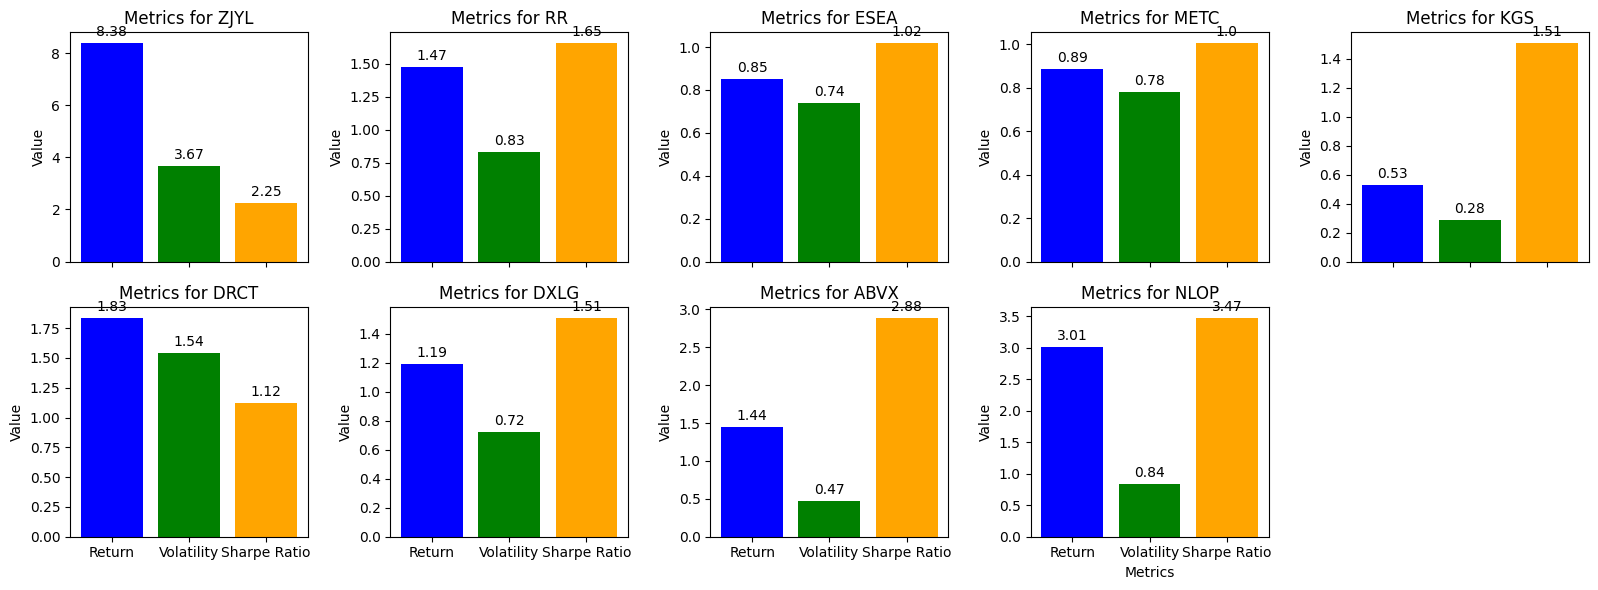

In [129]:
plot_metrics(diversified_and_risk_adjusted_portfolio)

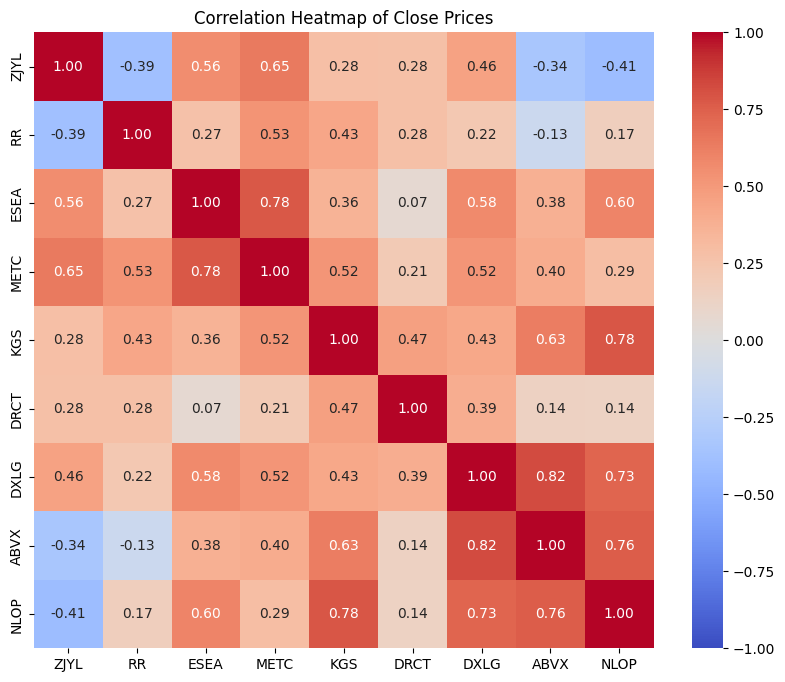

In [130]:
plot_close_correlation_heatmap(diversified_and_risk_adjusted_portfolio)

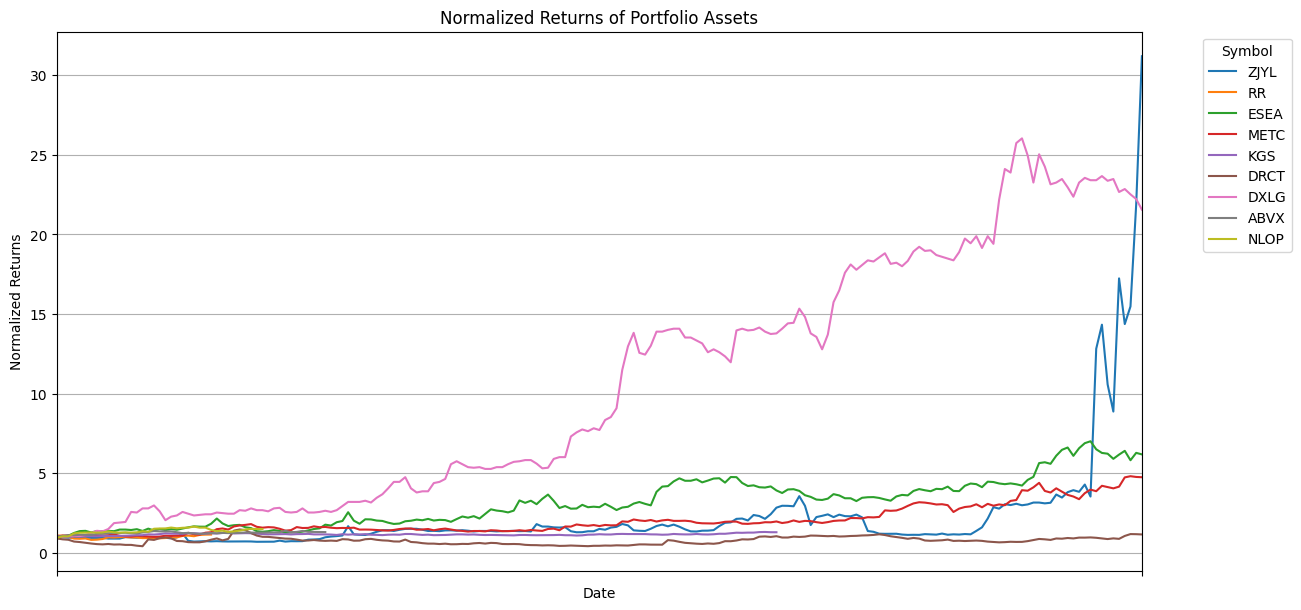

In [131]:
plot_normalized_portfolio_returns(diversified_and_risk_adjusted_portfolio)

### Construct an artificial asset that represents the portfolio

In [156]:
generic_asset = create_composite_asset(
                    diversified_and_risk_adjusted_portfolio, 
                    optimize_portfolio_weights(diversified_and_risk_adjusted_portfolio)
                )

generic_asset.set_index('date', inplace=True)

### Comparison of Portfolio against some benchmarks

In [160]:
def fetch_data(ticker, start_date, end_date):
    """Fetches adjusted close prices from Yahoo Finance for a given ticker within specified dates."""
    data = yf.download(ticker, start=start_date, end=end_date)
    if data.empty:
        print(f"No data fetched for {ticker}.")
    return data['Adj Close']

def calculate_returns(price_series):
    """Calculates daily returns from a time series of prices."""
    returns = price_series.pct_change().dropna()  # Calculate percent change and drop the first NaN
    return returns

import matplotlib.pyplot as plt

def plot_normalized_generic_returns(benchmark_data, generic_asset):
    # Set the figure size right at the beginning
    plt.figure(figsize=(14, 7))

    # Process and plot each benchmark asset
    for sym, data in benchmark_data.items():
        # Calculate the daily returns and the normalized cumulative returns
        daily_returns = data.pct_change().dropna()
        normalized_daily_returns = (1 + daily_returns).cumprod()

        # Plotting the asset data
        plt.plot(normalized_daily_returns, label=f'{sym} Returns')

    # Process and plot the generic asset
    daily_returns = generic_asset['adj_close'].pct_change().dropna()
    normalized_generic_returns = (1 + daily_returns).cumprod()
    
    # Plotting the generic asset data
    plt.plot(normalized_generic_returns, label='Generic Asset Returns')

    # Setup the plot with titles, labels, grid and legend
    plt.title('Normalized Returns Comparison Including Generic Asset')
    plt.xlabel('Date')
    plt.ylabel('Normalized Returns')
    plt.legend(title='Asset')
    plt.grid(True)

    # Show the plot
    plt.show()
    

In [283]:
def compare_normalized_returns(benchmark_data, generic_asset):
    # Create a DataFrame to hold normalized returns
    normalized_returns = pd.DataFrame()

    # Process and store normalized returns for each benchmark asset
    for sym, data in benchmark_data.items():
        daily_returns = data.pct_change().dropna()
        normalized_returns[sym] = (1 + daily_returns).cumprod()

    # Process and store normalized returns for the generic asset
    generic_daily_returns = generic_asset['adj_close'].pct_change().dropna()
    normalized_returns['Generic Asset'] = (1 + generic_daily_returns).cumprod()

    # Get the last normalized return value for each series for comparison
    final_returns = normalized_returns.iloc[-1]

    # Calculate performance relative to the generic asset
    relative_performance = (final_returns / final_returns['Generic Asset'] - 1) * 100
    relative_performance = relative_performance.drop('Generic Asset')  # Remove self comparison

    # Print the comparison table
    print("Final Normalized Returns Comparison:")
    comparison_df = pd.DataFrame({
        'Asset': final_returns.index,
        'Total Returns': final_returns.values,
        'Relative Returns (%)': relative_performance.reindex(final_returns.index).fillna(0).values
    })
    print(comparison_df)

    # Plotting the relative performance
    relative_performance.plot(kind='bar', figsize=(10, 5), color='skyblue')
    plt.title('Performance Relative to Generic Asset')
    plt.ylabel('Percentage')
    plt.axhline(0, color='red', linewidth=0.8)  # Add a line at 0% for reference
    plt.grid(True, linestyle='--')
    plt.show()

    return final_returns['Generic Asset']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


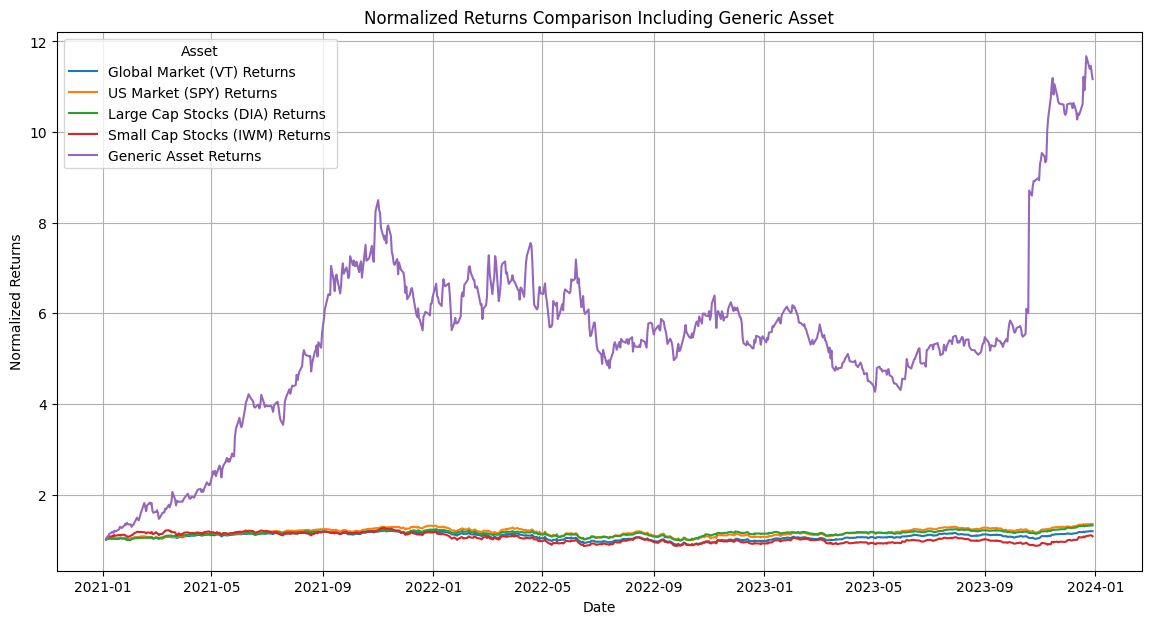

Final Normalized Returns Comparison:
                    Asset  Total Returns  Relative Returns (%)
0      Global Market (VT)           1.19                -89.34
1         US Market (SPY)           1.35                -87.93
2  Large Cap Stocks (DIA)           1.32                -88.19
3  Small Cap Stocks (IWM)           1.08                -90.35
4           Generic Asset          11.17                  0.00


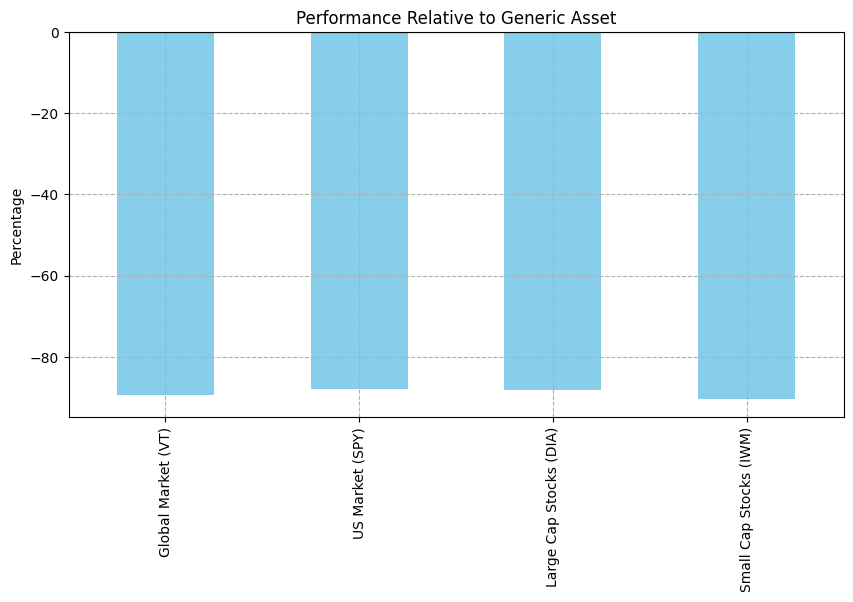

In [284]:
# Benchmark Tickers
tickers = {
    'Global Market (VT)': 'VT',
    'US Market (SPY)': 'SPY',
    'Large Cap Stocks (DIA)': 'DIA',
    'Small Cap Stocks (IWM)': 'IWM'
}

# Fetch and store ndata in a dictionary
benchmark_data = {name: fetch_data(ticker, start_date, end_date) for name, ticker in tickers.items()}




# Example usage assuming data_dict is already populated with your financial data.
plot_normalized_generic_returns(benchmark_data, generic_asset)
generic_asset_returns = compare_normalized_returns(benchmark_data, generic_asset)

## Store results in a new keyspace

In [318]:
def insert_portfolio_performance(session, portfolio_id, ticker_symbols, weights, start_date, end_date, total_return):
    query = """
    INSERT INTO portfolio_performance (portfolio_id, ticker_symbols, weights, start_date, end_date, total_return)
    VALUES (?, ?, ?, ?, ?, ?)
    """
    prepared = session.prepare(query)
    session.execute(prepared, [portfolio_id, ticker_symbols, weights, start_date, end_date, total_return])


In [327]:
def list_tables_in_keyspace(keyspace_name, username='cassandra', password='cassandra', hosts=['127.0.0.1']):
    
    # Connect to Cassandra
    auth_provider = PlainTextAuthProvider(username=username, password=password)
    cluster = Cluster(hosts, auth_provider=auth_provider)
    session = cluster.connect(keyspace_name)  # Connect to the specified keyspace

    try:
        # List all tables in the keyspace
        rows = session.execute("SELECT table_name FROM system_schema.tables WHERE keyspace_name = %s;", [keyspace_name])
        tables = [row.table_name for row in rows]
        print(f"Tables in '{keyspace_name}' keyspace:")

        for table in tables:
            print(f"\nTable: {table}")
            # Retrieve and print contents of each table
            query = f"SELECT * FROM {table} LIMIT 10;"  # Limit for demonstration purposes
            contents = session.execute(query)
            print(f"Contents of table {table}:")
            for content in contents:
                print(content)

    finally:
        # Ensure the session and cluster are closed
        session.shutdown()
        cluster.shutdown()

In [320]:
def empty_keyspace(keyspace_name, username='cassandra', password='cassandra', hosts=['127.0.0.1']):
    # Connect to Cassandra
    auth_provider = PlainTextAuthProvider(username=username, password=password)
    cluster = Cluster(hosts, auth_provider=auth_provider)
    session = cluster.connect(keyspace_name)  # Connect to the specified keyspace directly


    try:
        # Retrieve all table names from the keyspace
        tables = session.execute(f"SELECT table_name FROM system_schema.tables WHERE keyspace_name = '{keyspace_name}';")
        table_names = [table.table_name for table in tables]

        # Truncate each table
        for table_name in table_names:
            print(f"Truncating table {table_name}...")
            session.execute(f"TRUNCATE TABLE {table_name};")
            print(f"Table {table_name} has been emptied.")
            
        print(f"All tables in keyspace '{keyspace_name}' have been emptied.")
    finally:
        # Clean up, ensure the session and cluster are closed
        session.shutdown()
        cluster.shutdown()

In [321]:
def drop_keyspace(keyspace_name, username='cassandra', password='cassandra', hosts=['127.0.0.1']):
    # Connect to Cassandra
    auth_provider = PlainTextAuthProvider(username=username, password=password)
    cluster = Cluster(hosts, auth_provider=auth_provider)
    session = cluster.connect()  # Connect without specifying a keyspace

    try:
        # Drop the keyspace
        session.execute(f"DROP KEYSPACE IF EXISTS {keyspace_name};")
        print(f"Keyspace '{keyspace_name}' has been successfully dropped.")
    except Exception as e:
        print(f"An error occurred while dropping the keyspace: {e}")
    finally:
        # Clean up, ensure the session and cluster are closed
        session.shutdown()
        cluster.shutdown()

In [325]:
auth_provider = PlainTextAuthProvider(username='cassandra', password='cassandra')  # Update credentials if needed
cluster = Cluster(['127.0.0.1'], auth_provider=auth_provider)  
session = cluster.connect('portfolio_data')

try:
    # Compute the SHA-256 hash as a portfolio identifier
    portfolio_id = uuid.uuid4()
    weights = optimize_portfolio_weights(diversified_and_risk_adjusted_portfolio)


    # Insert data into Cassandra
    insert_portfolio_performance(
        session, 
        portfolio_id, 
        diversified_and_risk_adjusted_portfolio.index.tolist(), 
        weights,
        start_date, 
        end_date, 
        generic_asset_returns
    )

finally:
    # Clean up, ensure the session and cluster are closed
    session.shutdown()
    cluster.shutdown()


In [326]:

# Example usage
#empty_keyspace('portfolio_data')
# Example usage
#drop_keyspace('portfolio_data')


list_tables_in_keyspace('portfolio_data')

Tables in 'portfolio_data' keyspace:

Table: portfolio_performance
Contents of table portfolio_performance:
Row(portfolio_id=UUID('56fa9781-12c1-47a0-b370-4d74897d9ac1'), end_date=Date(19723), start_date=Date(18628), ticker_symbols=['ZJYL', 'RR', 'ESEA', 'METC', 'KGS', 'DRCT', 'DXLG', 'ABVX', 'NLOP'], total_return=Decimal('11.16741082640644577850252971984446048736572265625'), weights=OrderedMapSerializedKey([('ABVX', Decimal('0.1892614120475902550477798058636835776269435882568359375')), ('DRCT', Decimal('2.77555756156289135105907917022705078125E-17')), ('DXLG', Decimal('0.47866510932296646441130860694102011620998382568359375')), ('ESEA', Decimal('0.0502375320139754055759340189979411661624908447265625')), ('KGS', Decimal('0.06037110334251984122833079027259373106062412261962890625')), ('METC', Decimal('0.22146484327294813088116143262595869600772857666015625')), ('NLOP', Decimal('0')), ('RR', Decimal('0')), ('ZJYL', Decimal('0'))]))
